In [41]:
import numpy as np
import os
from sklearn.utils import shuffle
from imblearn.combine import SMOTEENN
from PIL import Image
import scipy
import pickle

In [16]:
import cv2

def reshape_images(folder_path, new_width, new_height):
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Read the image
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Unable to read image '{filename}'")
                continue
            
            # Resize the image
            resized_img = cv2.resize(img, (new_width, new_height))
            
            # Save the resized image
            cv2.imwrite(image_path, resized_img)
            print(f"Resized and saved '{filename}'")

In [20]:
folder_path = './data/Dataset/Very_Mild_Demented/'
new_width = 170
new_height = 170

reshape_images(folder_path, new_width, new_height)

Resized and saved 'verymild.jpg'
Resized and saved 'verymild_10.jpg'
Resized and saved 'verymild_100.jpg'
Resized and saved 'verymild_1000.jpg'
Resized and saved 'verymild_1001.jpg'
Resized and saved 'verymild_1002.jpg'
Resized and saved 'verymild_1003.jpg'
Resized and saved 'verymild_1004.jpg'
Resized and saved 'verymild_1005.jpg'
Resized and saved 'verymild_1006.jpg'
Resized and saved 'verymild_1007.jpg'
Resized and saved 'verymild_1008.jpg'
Resized and saved 'verymild_1009.jpg'
Resized and saved 'verymild_101.jpg'
Resized and saved 'verymild_1010.jpg'
Resized and saved 'verymild_1011.jpg'
Resized and saved 'verymild_1012.jpg'
Resized and saved 'verymild_1013.jpg'
Resized and saved 'verymild_1014.jpg'
Resized and saved 'verymild_1015.jpg'
Resized and saved 'verymild_1016.jpg'
Resized and saved 'verymild_1017.jpg'
Resized and saved 'verymild_1018.jpg'
Resized and saved 'verymild_1019.jpg'
Resized and saved 'verymild_102.jpg'
Resized and saved 'verymild_1020.jpg'
Resized and saved 'ver

In [7]:
def load_and_preprocess_images(folder_path):
    images = []
    labels = []

    for class_label, class_folder in enumerate(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_folder)
        for file_name in os.listdir(class_path):
            image_path = os.path.join(class_path, file_name)
            # Read and resize images to a consistent size (e.g., 100x100) using Pillow
            img = Image.open(image_path).convert('RGB')
            img = img.resize((100, 100))  # Adjust size as needed
            images.append(np.array(img))
            labels.append(class_folder)

    return np.array(images), np.array(labels)

In [9]:
image_folder_path = "./data/Dataset/"
X, y =load_and_preprocess_images(image_folder_path)

In [11]:
# Combine SMOTE and ENN for resampling
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X.reshape(-1, 100*100*3),y)

In [12]:
# Shuffle the resampled data
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

In [25]:
# Save the resampled images to a new folder
resampled_folder_path = "./data/Resampled_dataset/"
for i, (image, label) in enumerate(zip(X_resampled, y_resampled)):
    class_folder = os.path.join(resampled_folder_path, label)
    os.makedirs(class_folder, exist_ok=True)
    image_path = os.path.join(class_folder, f'image_{i}.jpg')
    Image.fromarray(image.reshape(100, 100, 3).astype('uint8')).save(image_path)

# Split dataset

In [38]:
import os
import shutil
import random

def split_dataset(input_dir, output_dir1, output_dir2, output_dir3, split_ratio1=0.6, split_ratio2=0.2):
    # Get the list of image files in the input directory
    image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    # Shuffle the list of files for randomness (optional)
    random.shuffle(image_files)

    # Calculate the split indices
    split_index1 = int(len(image_files) * split_ratio1)
    split_index2 = int(len(image_files) * (split_ratio1 + split_ratio2))

    # Split the list into three parts
    first_part = image_files[:split_index1]
    second_part = image_files[split_index1:split_index2]
    third_part = image_files[split_index2:]

    # Copy or move the files to the output directories
    copy_files(first_part, input_dir, output_dir1)
    copy_files(second_part, input_dir, output_dir2)
    copy_files(third_part, input_dir, output_dir3)

def copy_files(file_list, source_dir, dest_dir):
    for file in file_list:
        source_path = os.path.join(source_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.copy(source_path, dest_path)  # Use shutil.move if you want to move instead of copy


In [42]:
input_folder = './data/Resampled_dataset/Very_Mild_Demented/'
output_train = './data/train/Very_Mild_Demented/'
output_val = './data/val/Very_Mild_Demented/'
output_test = './data/test/Very_Mild_Demented/'

os.makedirs(output_train, exist_ok=True)
os.makedirs(output_val, exist_ok=True)
os.makedirs(output_test, exist_ok=True)

split_dataset(input_folder, output_train, output_val, output_test)

# Model

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout

In [3]:
train_dir = './data/train/'
validation_dir = './data/val/'
test_dir = './data/test/'

In [6]:
input_shape = (100, 100, 3)
num_classes = 4
batch_size = 32
epochs = 100

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6745 images belonging to 4 classes.
Found 2249 images belonging to 4 classes.


In [8]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
210/210 [==============================] - 24s 113ms/step - loss: 0.1756 - accuracy: 0.9353 - val_loss: 0.1956 - val_accuracy: 0.9384
Epoch 2/100
210/210 [==============================] - 24s 114ms/step - loss: 0.1692 - accuracy: 0.9380 - val_loss: 0.2044 - val_accuracy: 0.9353
Epoch 3/100
210/210 [==============================] - 23s 111ms/step - loss: 0.1634 - accuracy: 0.9349 - val_loss: 0.2004 - val_accuracy: 0.9442
Epoch 4/100
210/210 [==============================] - 22s 104ms/step - loss: 0.1661 - accuracy: 0.9348 - val_loss: 0.1973 - val_accuracy: 0.9353
Epoch 5/100
210/210 [==============================] - 20s 94ms/step - loss: 0.1655 - accuracy: 0.9379 - val_loss: 0.3393 - val_accuracy: 0.9031
Epoch 6/100
210/210 [==============================] - 19s 89ms/step - loss: 0.1675 - accuracy: 0.9337 - val_loss: 0.2170 - val_accuracy: 0.9375
Epoch 7/100
210/210 [==============================] - 19s 89ms/step - loss: 0.1626 - accuracy: 0.9377 - val_loss: 0.2198 - va

In [12]:
model2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [13]:
model2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [14]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 average_pooling2d_2 (Averag  (None, 10, 10, 64)      

In [35]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10
210/210 [==============================] - 16s 77ms/step - loss: 0.0871 - accuracy: 0.9666 - val_loss: 0.1025 - val_accuracy: 0.9723
Epoch 2/10
210/210 [==============================] - 16s 76ms/step - loss: 0.0904 - accuracy: 0.9659 - val_loss: 0.1772 - val_accuracy: 0.9522
Epoch 3/10
210/210 [==============================] - 16s 77ms/step - loss: 0.1008 - accuracy: 0.9626 - val_loss: 0.1798 - val_accuracy: 0.9491
Epoch 4/10
210/210 [==============================] - 17s 80ms/step - loss: 0.1027 - accuracy: 0.9610 - val_loss: 0.1536 - val_accuracy: 0.9527
Epoch 5/10
210/210 [==============================] - 17s 79ms/step - loss: 0.0899 - accuracy: 0.9654 - val_loss: 0.1423 - val_accuracy: 0.9598
Epoch 6/10
210/210 [==============================] - 16s 77ms/step - loss: 0.1039 - accuracy: 0.9607 - val_loss: 0.1521 - val_accuracy: 0.9567
Epoch 7/10
210/210 [==============================] - 17s 78ms/step - loss: 0.0809 - accuracy: 0.9693 - val_loss: 0.1767 - val_accuracy:

In [36]:
model2.save("./final_model_01.h5")

In [42]:
with open("./final_model_01.pkl", "wb") as f:
    pickle.dump(model2, f)

INFO:tensorflow:Assets written to: ram://029abcf7-eab6-470d-bd74-b3b6c98ed5a8/assets


INFO:tensorflow:Assets written to: ram://029abcf7-eab6-470d-bd74-b3b6c98ed5a8/assets


In [37]:
loaded_model = tf.keras.models.load_model("./final_model_01.h5")

# Prediction

In [77]:
import numpy as np

test_image_path = './try2.jpg'
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(input_shape[0], input_shape[1]))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.0  # Normalize

prediction = model2.predict(test_image)
predicted_class = np.argmax(prediction)
print("Predicted class:", predicted_class)

class_names = ['MD', 'MOD', 'ND', 'VMD']
print("Predicted class:", class_names[predicted_class])


1/1 [==============================] - 0s 21ms/step
Predicted class: 2
Predicted class: ND


In [65]:
# Assuming you have defined your classes as a list
classes = ['', '', '', '']

# Get the predicted class index
predicted_class_index = np.argmax(prediction)
print("Predicted class index:", predicted_class_index)

# Map the predicted class index to the corresponding class label
predicted_class_label = classes[predicted_class_index]
print("Predicted class label:", predicted_class_label)


Predicted class index: 3
Predicted class label: class_4


In [16]:
model3 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [17]:
model3.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 average_pooling2d_4 (Averag  (None, 10, 10, 64)      

In [ ]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
210/210 [==============================] - 20s 93ms/step - loss: 1.0548 - accuracy: 0.5217 - val_loss: 1.1904 - val_accuracy: 0.4741
Epoch 2/100
210/210 [==============================] - 19s 91ms/step - loss: 0.9715 - accuracy: 0.5534 - val_loss: 1.0734 - val_accuracy: 0.5652
Epoch 3/100
210/210 [==============================] - 19s 91ms/step - loss: 0.9378 - accuracy: 0.5799 - val_loss: 0.9270 - val_accuracy: 0.6076
Epoch 4/100
210/210 [==============================] - 19s 91ms/step - loss: 0.8927 - accuracy: 0.5957 - val_loss: 0.8741 - val_accuracy: 0.6138
Epoch 5/100
210/210 [==============================] - 19s 89ms/step - loss: 0.8534 - accuracy: 0.6133 - val_loss: 0.9745 - val_accuracy: 0.5478
Epoch 6/100
210/210 [==============================] - 20s 93ms/step - loss: 0.8078 - accuracy: 0.6355 - val_loss: 0.7358 - val_accuracy: 0.6598
Epoch 7/100
210/210 [==============================] - 19s 89ms/step - loss: 0.7722 - accuracy: 0.6478 - val_loss: 0.7394 - val_ac

In [19]:
model4 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [20]:
model4.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 average_pooling2d_6 (Averag  (None, 49, 49, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 average_pooling2d_7 (Averag  (None, 23, 23, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 64)      

In [ ]:
history4 = model4.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
210/210 [==============================] - 20s 94ms/step - loss: 1.0796 - accuracy: 0.5126 - val_loss: 0.9695 - val_accuracy: 0.5844
Epoch 2/100
210/210 [==============================] - 19s 90ms/step - loss: 0.9827 - accuracy: 0.5570 - val_loss: 0.9783 - val_accuracy: 0.5844
Epoch 3/100
210/210 [==============================] - 19s 91ms/step - loss: 0.9397 - accuracy: 0.5686 - val_loss: 0.9487 - val_accuracy: 0.5987
Epoch 4/100
210/210 [==============================] - 19s 88ms/step - loss: 0.8812 - accuracy: 0.5936 - val_loss: 0.8028 - val_accuracy: 0.6366
Epoch 5/100
210/210 [==============================] - 19s 88ms/step - loss: 0.8287 - accuracy: 0.6230 - val_loss: 0.9238 - val_accuracy: 0.5987
Epoch 6/100
210/210 [==============================] - 18s 88ms/step - loss: 0.7847 - accuracy: 0.6496 - val_loss: 0.7079 - val_accuracy: 0.6625
Epoch 7/100
210/210 [==============================] - 18s 88ms/step - loss: 0.7322 - accuracy: 0.6598 - val_loss: 0.6638 - val_ac

In [22]:
model5 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [23]:
model5.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)      

In [ ]:
history5 = model5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
210/210 [==============================] - 20s 91ms/step - loss: 1.0481 - accuracy: 0.5224 - val_loss: 1.1612 - val_accuracy: 0.4527
Epoch 2/100
210/210 [==============================] - 19s 89ms/step - loss: 0.9691 - accuracy: 0.5547 - val_loss: 0.8853 - val_accuracy: 0.5857
Epoch 3/100
210/210 [==============================] - 19s 88ms/step - loss: 0.9237 - accuracy: 0.5784 - val_loss: 0.9451 - val_accuracy: 0.5866
Epoch 4/100
210/210 [==============================] - 19s 88ms/step - loss: 0.8881 - accuracy: 0.5914 - val_loss: 0.8731 - val_accuracy: 0.6259
Epoch 5/100
210/210 [==============================] - 19s 88ms/step - loss: 0.8447 - accuracy: 0.6191 - val_loss: 0.7681 - val_accuracy: 0.6362
Epoch 6/100
210/210 [==============================] - 19s 88ms/step - loss: 0.7920 - accuracy: 0.6383 - val_loss: 0.8083 - val_accuracy: 0.6451
Epoch 7/100
210/210 [==============================] - 18s 88ms/step - loss: 0.7313 - accuracy: 0.6700 - val_loss: 0.7272 - val_ac

In [25]:
model6 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [26]:
model6.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 average_pooling2d_9 (Averag  (None, 49, 49, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_21 (Conv2D)          (None, 47, 47, 32)        4640      
                                                                 
 average_pooling2d_10 (Avera  (None, 23, 23, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_22 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 average_pooling2d_11 (Avera  (None, 10, 10, 64)      

In [ ]:
history6 = model6.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100
210/210 [==============================] - 20s 92ms/step - loss: 1.1286 - accuracy: 0.4826 - val_loss: 1.5340 - val_accuracy: 0.3518
Epoch 2/100
210/210 [==============================] - 19s 90ms/step - loss: 0.9837 - accuracy: 0.5513 - val_loss: 1.0747 - val_accuracy: 0.5286
Epoch 3/100
210/210 [==============================] - 19s 89ms/step - loss: 0.9582 - accuracy: 0.5595 - val_loss: 1.1200 - val_accuracy: 0.4830
Epoch 4/100
210/210 [==============================] - 19s 88ms/step - loss: 0.9208 - accuracy: 0.5832 - val_loss: 0.9129 - val_accuracy: 0.6170
Epoch 5/100
210/210 [==============================] - 19s 89ms/step - loss: 0.8735 - accuracy: 0.6002 - val_loss: 0.8801 - val_accuracy: 0.6272
Epoch 6/100
210/210 [==============================] - 19s 88ms/step - loss: 0.8187 - accuracy: 0.6222 - val_loss: 0.7694 - val_accuracy: 0.6612
Epoch 7/100
210/210 [==============================] - 19s 89ms/step - loss: 0.7858 - accuracy: 0.6382 - val_loss: 0.7364 - val_ac

In [ ]:
model7 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(128, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),  # Adjusted pool size to maintain feature map size
    Conv2D(256, (3, 3), activation='relu'),
    AveragePooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model7.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model7.summary()

In [ ]:
history7 = model7.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=220,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2249 images belonging to 4 classes.


In [39]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy model:", test_acc)

test_loss, test_acc = model2.evaluate(test_generator)
print("Test accuracy model2:", test_acc)

test_loss, test_acc = model3.evaluate(test_generator)
print("Test accuracy model3:", test_acc)

test_loss, test_acc = model4.evaluate(test_generator)
print("Test accuracy model4:", test_acc)

test_loss, test_acc = model5.evaluate(test_generator)
print("Test accuracy model5:", test_acc)

test_loss, test_acc = model6.evaluate(test_generator)
print("Test accuracy model6:", test_acc)

71/71 [==============================] - 1s 20ms/step - loss: 0.1430 - accuracy: 0.9471
Test accuracy model: 0.9470875859260559
71/71 [==============================] - 1s 17ms/step - loss: 0.1702 - accuracy: 0.9506
Test accuracy model2: 0.9506447315216064
71/71 [==============================] - 1s 18ms/step - loss: 0.2047 - accuracy: 0.9360
Test accuracy model3: 0.9359715580940247
71/71 [==============================] - 1s 17ms/step - loss: 0.2287 - accuracy: 0.9200
Test accuracy model4: 0.9199644327163696
71/71 [==============================] - 1s 17ms/step - loss: 0.2085 - accuracy: 0.9266
Test accuracy model5: 0.9266340732574463
71/71 [==============================] - 1s 18ms/step - loss: 0.2097 - accuracy: 0.9315
Test accuracy model6: 0.9315251111984253


# Grad Cam

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [90]:
# Function to generate Grad-CAM
def generate_grad_cam(model, img_path, class_index, layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate_model = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate_model(img_array)
        class_output = model_out[:, class_index]

    grads = tape.gradient(class_output, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [ ]:
def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.4 + img

    cv2.imwrite('grad_cam_result.jpg', superimposed_img)

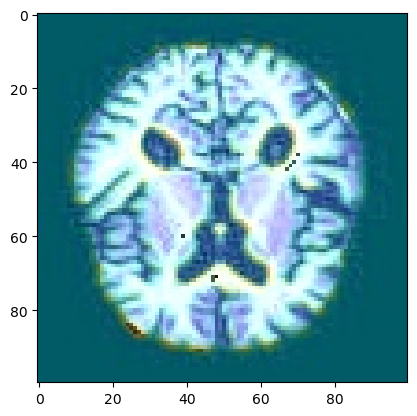

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model
base_model = tf.keras.models.load_model("./final_model_01.h5")
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv2d_4').output)

# Function to generate Grad-CAM
def generate_grad_cam(model, img_path, class_index, layer_name):
    img = keras.preprocessing.image.load_img(img_path, target_size=(100,100))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate_model = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate_model(img_array)
        class_output = model_out[:, class_index]

    grads = tape.gradient(class_output, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay Grad-CAM on the original image
def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.4 + img

    cv2.imwrite('grad_cam_result.jpg', superimposed_img)

# Specify the path to the image you want to visualize
img_path = './data/test/Moderate_Demented/image_204.jpg'

# Specify the target class index
class_index = 1  # Example index for 'zebra' in ImageNet

# Specify the layer name from which to compute Grad-CAM
layer_name = 'conv2d_4'

# Generate Grad-CAM
heatmap = generate_grad_cam(model, img_path, class_index, layer_name)

# Overlay Grad-CAM on the original image
overlay_grad_cam(img_path, heatmap)

# Display the result
result_img = cv2.imread('grad_cam_result.jpg')
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()

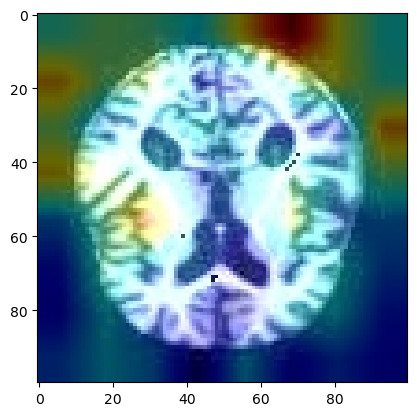

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model (VGG16 in this example)
base_model = tf.keras.models.load_model("./final_model_01.h5")
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv2d_7').output)

# Function to generate Grad-CAM
def generate_grad_cam(model, img_path, class_index, layer_name):
    img = keras.preprocessing.image.load_img(img_path, target_size=(100,100))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate_model = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate_model(img_array)
        class_output = model_out[:, class_index]

    grads = tape.gradient(class_output, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay Grad-CAM on the original image
def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.4 + img

    cv2.imwrite('grad_cam_result.jpg', superimposed_img)

# Specify the path to the image you want to visualize
img_path = './data/test/Moderate_Demented/image_204.jpg'

# Specify the target class index
class_index = 1  # Example index for 'zebra' in ImageNet

# Specify the layer name from which to compute Grad-CAM
layer_name = 'conv2d_7'

# Generate Grad-CAM
heatmap = generate_grad_cam(model, img_path, class_index, layer_name)

# Overlay Grad-CAM on the original image
overlay_grad_cam(img_path, heatmap)

# Display the result
result_img = cv2.imread('grad_cam_result.jpg')
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()

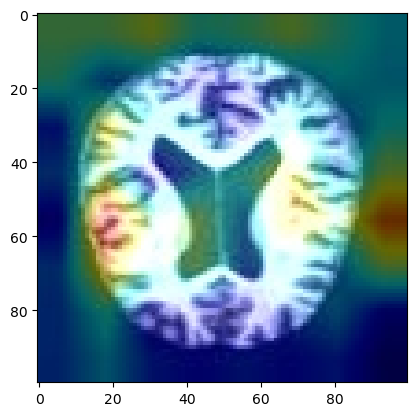

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model (VGG16 in this example)
base_model = tf.keras.models.load_model("./final_model_01.h5")
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv2d_7').output)

# Function to generate Grad-CAM
def generate_grad_cam(model, img_path, class_index, layer_name):
    img = keras.preprocessing.image.load_img(img_path, target_size=(100,100))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(layer_name)
        iterate_model = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate_model(img_array)
        class_output = model_out[:, class_index]

    grads = tape.gradient(class_output, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

# Function to overlay Grad-CAM on the original image
def overlay_grad_cam(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * 0.4 + img

    cv2.imwrite('grad_cam_result.jpg', superimposed_img)

# Specify the path to the image you want to visualize
img_path = './data/test/Non_Demented/image_11068.jpg'

# Specify the target class index
class_index = 1  # Example index for 'zebra' in ImageNet

# Specify the layer name from which to compute Grad-CAM
layer_name = 'conv2d_7'

# Generate Grad-CAM
heatmap = generate_grad_cam(model, img_path, class_index, layer_name)

# Overlay Grad-CAM on the original image
overlay_grad_cam(img_path, heatmap)

# Display the result
result_img = cv2.imread('grad_cam_result.jpg')
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()